# Prerequisite

This section is used to import packages to load data/files for the contents of this report. To run this notebook, change the FLUENT_HOME environment variable to the address of this repository

In [424]:
# Setting PYTHONPATHs & ENVIRONMENT VARIABLEs
import os
import sys
os.environ['FLUENT_HOME'] = r"C:\Users\lupus\OneDrive\GIT\OwnProjects\Speech Recognition\speech-to-intent"
sys.path.append(os.environ['FLUENT_HOME'] + '\\src')

In [425]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from trainer import Trainer

data = {}
data['train'] = np.load('../data/data_for_training.npz')
data['test'] = np.load('../data/test_data.npz')

best_model = '20210718005348'
metrics_df = pd.read_csv(f'../result/accuracies/{best_model}_merged_metrics_df.csv')
predictions_df = pd.read_csv(f'../result/predictions/{best_model}_predictions_df.csv')
with open(f'../result/models/{best_model}_model.pkl', 'rb') as f:
    trainer = pickle.load(f)

# Introduction

This project aims to design and implement a solution to recognize intents of speech using spectrograms. A train set consisting of 22,661 spectrograms and a test set consisting of 4,774 spectrograms are provided. Each spectrogram could be mapped to 1 out of 31 different intents. It is observed that the number of samples are evenly distributed among the 31 intents in both train dataset and test dataset

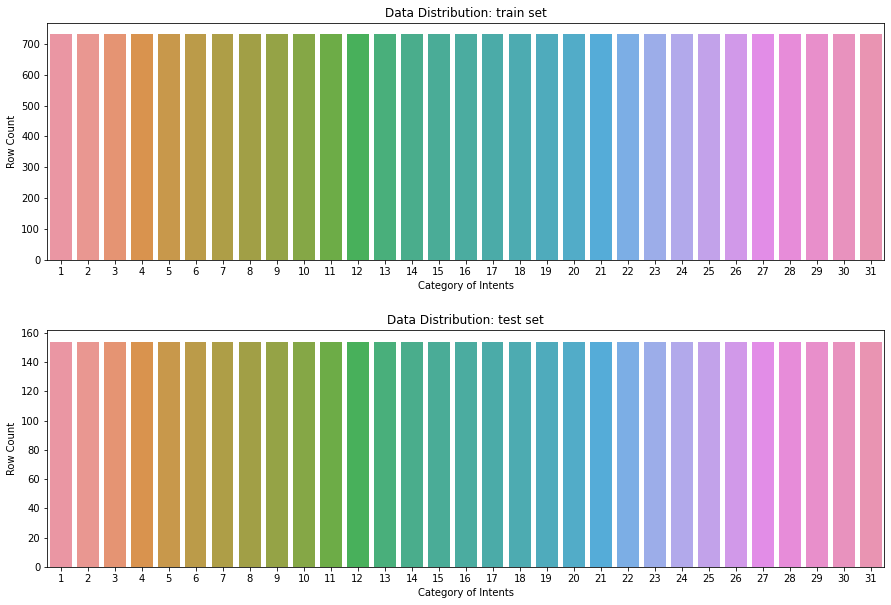

In [405]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for i, key in enumerate(data.keys()):
    unique, counts = np.unique(data[key]['f1'], return_counts=True)
    sns.barplot(x=unique, y=counts, ax=axes[i])
    axes[i].set_title(f'Data Distribution: {key} set')
    axes[i].set_xlabel('Category of Intents')
    axes[i].set_ylabel('Row Count')

Each spectrogram are arranged in a 3d array [sample, time, feature]. It is observed that each spectrogram shares the same number of dimensions. The time dimension is of size-300 while the feature dimension is of size-41. Below are some examples of the spectrograms from training dataset

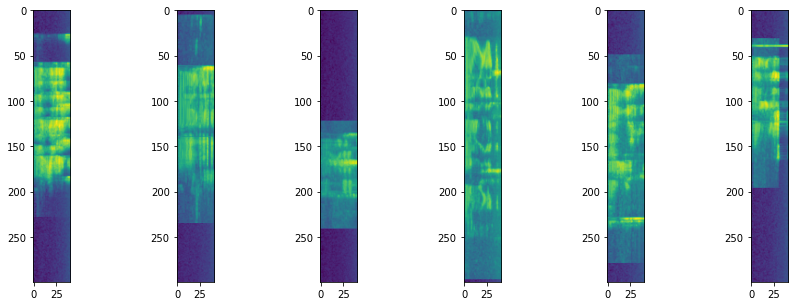

In [406]:
fig, axes = plt.subplots(ncols=6, figsize=(15,5))
for i, index in enumerate(np.random.choice(a=data['train']['f0'].shape[0], size=6)):
    axes[i].imshow(data['train']['f0'][index])

# Model Architecture 

CNN + LSTM + Linear Layer (Description) on the dimension.  

CNN is used to capture XXX. In this model, 16 channels, kernel size of 3 * 41, dilation of 2 along the time dimension. stride of 3 along the time dimension. Kernel-41 = piano keys.
Kernel-3, dilation-2, stride-3 = wider + touch every pixel

LSTM is used to capture XXX. 64 to allow sparse representation of latent space

Linear Layer is used to XXX. reduce the 64 hidden states into 31 prediction

In [484]:
print("Model Flow")

Model Flow


#### 2. Model Size

In [489]:
print("Model size\n")
for i in trainer.model.state_dict().keys():
    print(f'{i}:\t\t', trainer.model.state_dict()[i].shape)

Model size

cnn.weight:		 torch.Size([32, 1, 3, 41])
cnn.bias:		 torch.Size([32])
lstm.weight_ih_l0:		 torch.Size([256, 32])
lstm.weight_hh_l0:		 torch.Size([256, 64])
lstm.bias_ih_l0:		 torch.Size([256])
lstm.bias_hh_l0:		 torch.Size([256])
linear.weight:		 torch.Size([31, 64])
linear.bias:		 torch.Size([31])


# Training

### 1. Train-Validation Split

The training data was first **randomly splitted** into train set and validation set in order to support early stopping mechanism to avoids overfitting. **20%** of the training data was hold out as validation set with **stratified sampling**.

### 2. Loss Function, Epoch, Iteration, Batch Size & Learning Rate 

The **cross-entropy** loss was used as the loss function. The model was trained with **200 epochs, 32 iterations, 1024 batch size and 0.01 learning rate**. Instead of going through the whole training set, each epoch sampled 32 batch of data from the training set with 1024 samples per batch by sampling with replacement.

### 3. Early Stopping

An early stopping mechanism was applied to avoid overfitting. After each epoch, the validation set was inferenced and the validation loss was recorded. **The training was early stopped when the validation loss failed to improve for 20 epochs**. Then, the model parameters right after the epoch with lowest validation loss were used as the final model for evaluation on test set.

### 4. Data Augmentation

In order to increase robustness of the model and reduce overfitting, data augmentation strategy was applied during training. Each mini-batch of training data were first augmented by both **time masking** and **frequency masking**. For time masking, **10% out of the 300 timestamps** per spectrogram were masked. For frequency masking, **10% out of 41 features** per spectrogram were masked. The masking value was the mean value of the spectrograms per mini-batch.

# Results

To measure the result, a **softmax operation** was applied to the model's output in order to obtain the probability of each sample belonging to each possible intents. **The intent with the highest proability would be the predicted class of the model**. The **F1-Score, Recall and Precision** scores were then calculated for each intent. A **micro-average** of all 3 metrics were also calculated as an overall performance measure

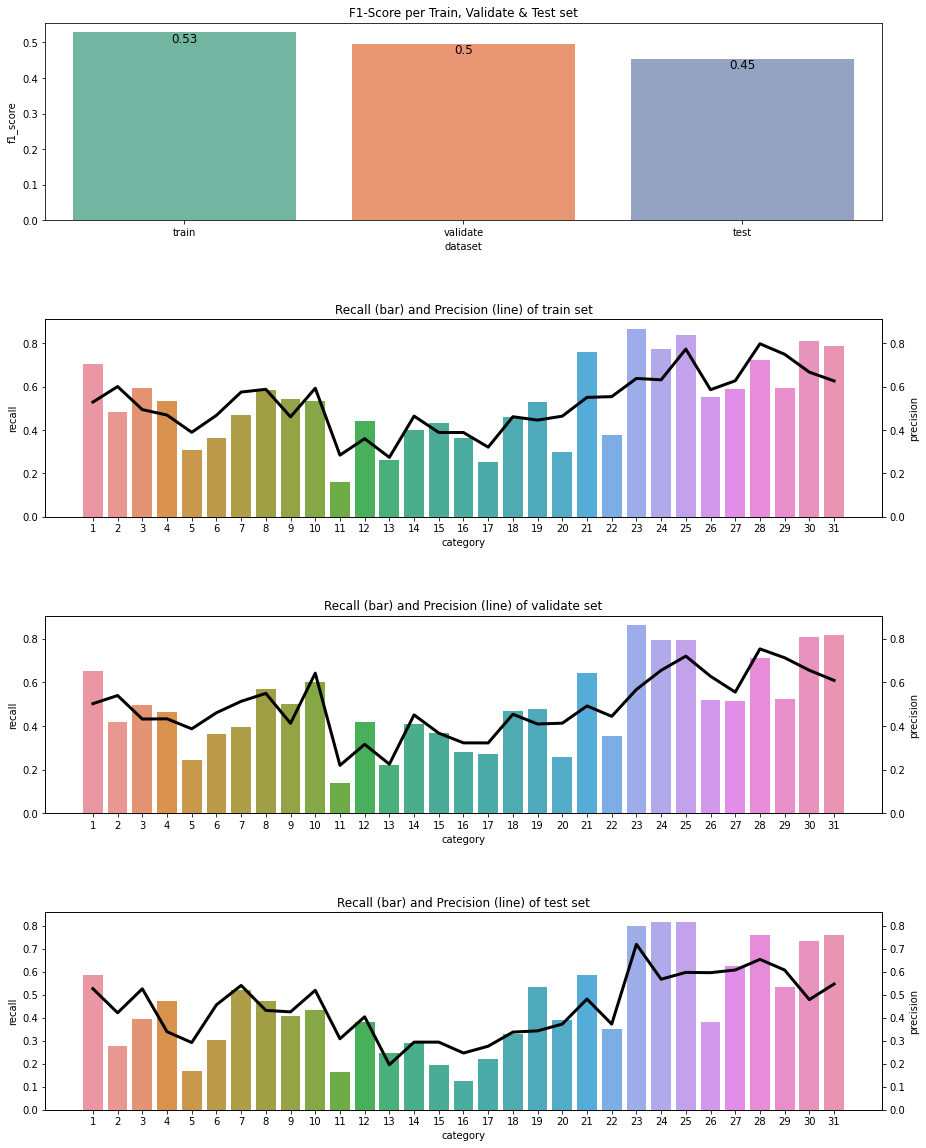

In [407]:
# Figure setting
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

# F1-Score bar plot
axes[0].set_title('F1-Score per Train, Validate & Test set')
axes[0] = sns.barplot(data=metrics_df[metrics_df.category=='micro-average'],
                      x="dataset", y="f1_score", ax=axes[0], orient='v', palette='Set2')
cols_order = ['train', 'validate', 'test']
grouped_df = metrics_df[metrics_df.category=='micro-average'].groupby('dataset')['f1_score'].sum().reindex(cols_order)
for index, row in grouped_df.reset_index().iterrows():
    axes[0].text(index, row.f1_score, round(row.f1_score,2), color='black', ha='center', va="top", fontsize=12)
    
    
# Precision and Recall
ax_pair = dict()
for idx, dataset in enumerate(cols_order, 1):
    df = metrics_df[(metrics_df.category!='micro-average') & (metrics_df.dataset == dataset)]
    sns.barplot(data=df, x="category", y="recall", ax=axes[idx])
    axes[idx].set_title(f'Recall (bar) and Precision (line) of {dataset} set')
#     axes[idx].set_ylabel("Recall (bar)")
    ax_pair[idx] = axes[idx].twinx()
#     ax_pair[idx].set_ylabel("Precision (line)")
    ax_pair[idx].sharey(axes[idx])
    ax_pair[idx] = sns.lineplot(data=df, x="category", y="precision", linewidth=3, color="black")

# Discussion

Based on the result, it is observed that the model's **accuracy for class 11, 12, 13 and 17 are obviously worse than other classes**. One possible explaination is that these classes are similar to each other, making it hard for the model to distinguish them. To verify the hypothesis, plot the confusion matrices for Train, Validate & Test set  

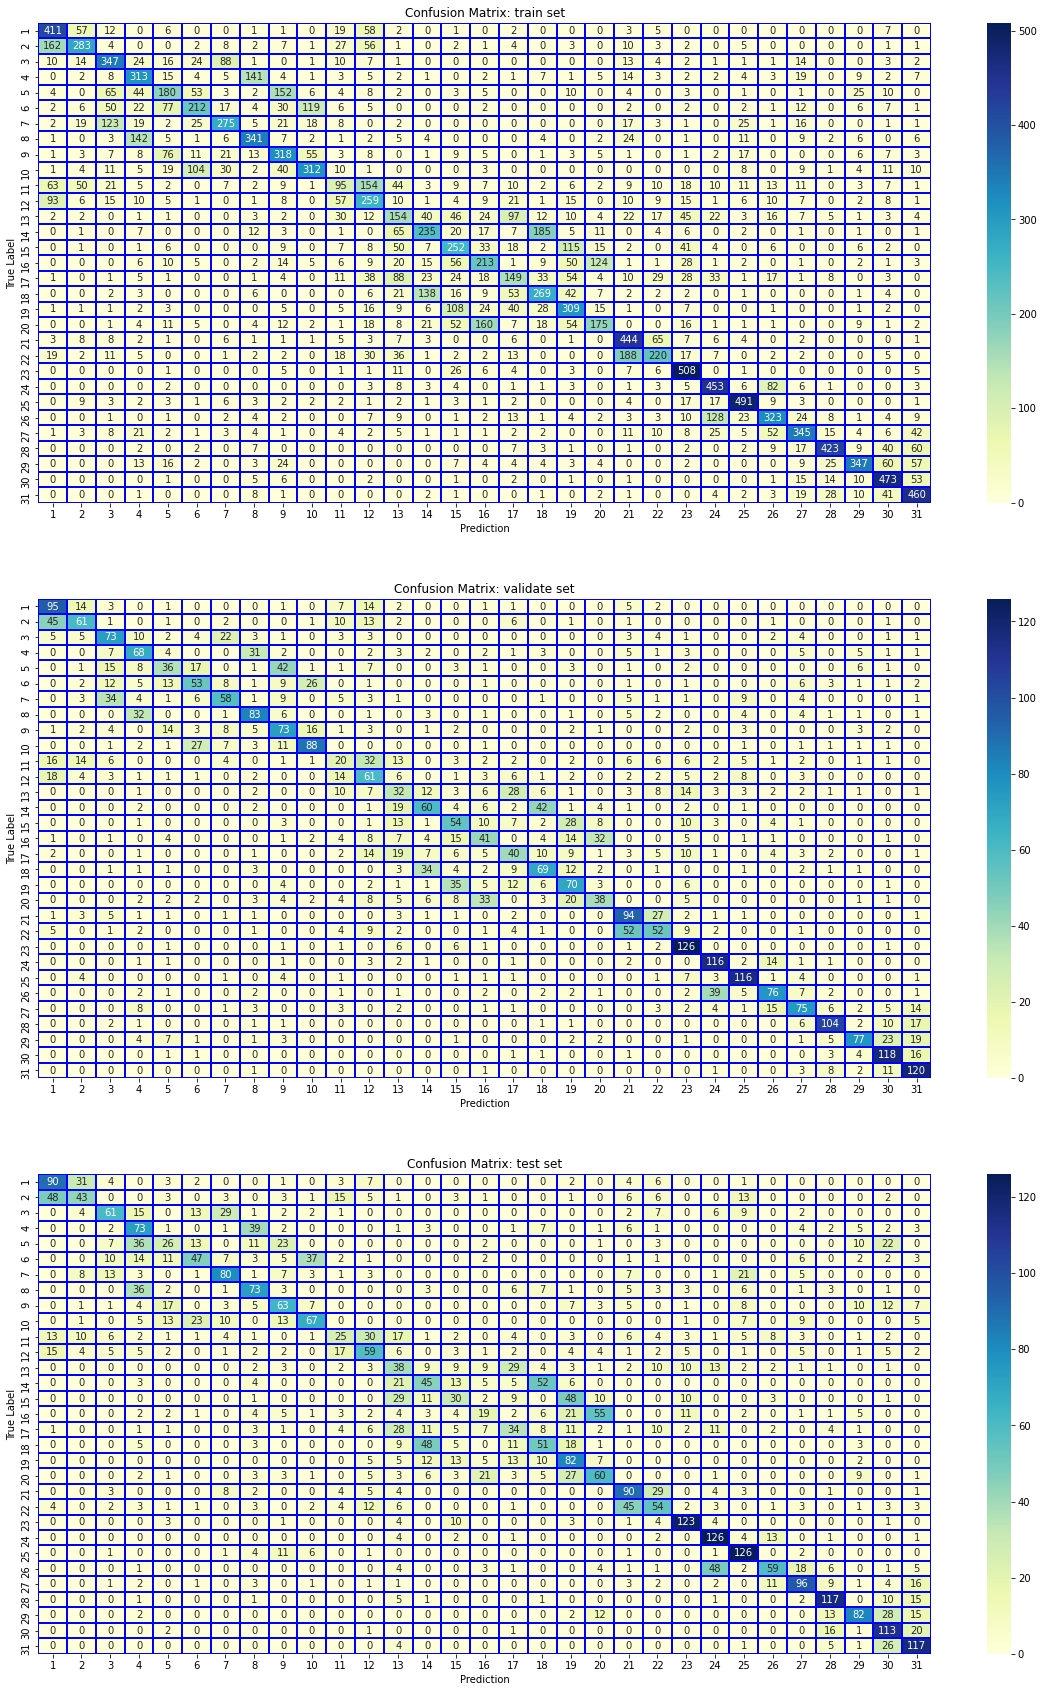

In [482]:
# Confusion Matrix
tick_labels = [str(i + 1) for i in range(31)]
fig, axes = plt.subplots(nrows=3, figsize=(20, 10 * 3))
for idx, keys in enumerate(['train', 'validate', 'test']):
    df = predictions_df[predictions_df.dataset == keys]
    sns.heatmap(data=confusion_matrix(df.label, df.predicted_class), ax=axes[idx]
                , xticklabels=tick_labels, yticklabels=tick_labels
                , cbar=True, cmap='YlGnBu', linewidths=.1, linecolor='b', annot=True, fmt='d')
    axes[idx].set_title(f'Confusion Matrix: {keys} set')
    axes[idx].set_xlabel('Prediction')
    axes[idx].set_ylabel('True Label')

Based on the confusion matrix of the validation set, it seems that **class 11 & 12 might be similar to each other** as their False Negative prediction mainly concentrated on each other. **For example, the model classified X samples with true label = class 11 as class 12. Conversely, the model classified X samples** with true label = class 12 as class 11. **This phenomenon also happens between class 13 & 17**

#### 2. Predicted probability

# Conclusion